# RUN experiments

In this notebook, we will run all the required experiments using the `Experiment` class, which can be found at `sscode/experiment.py`, and can be seen below:

```python
    class Experiment(object):
        """
        This class Experiment summarizes all the previous work done with the linear and the
        knn models, as this class allows the user to perform a detailed analysis of one
        requested model given a set of parameters

        """

        def __init__(self, slp_data, wind_data, ss_data, # this must have several stations
                     sites_to_analyze: list = list(np.random.randint(10,1000,5)),
                     model: str = 'linear', # this is the model to analyze
                     model_metrics: list = [
                         'bias','si','rmse','pearson','spearman','rscore',
                         'mae', 'me', 'expl_var', # ...
                     ], # these are the metrics to evaluate
                     pca_attrs: dict = pca_attrs_default,
                     model_attrs: dict = linear_attrs_default):
            """
            As the initializator, the __init__ funciton creates the instance of the class,
            given a set of parameters, which are described below

            Args:
                slp_data (xarray.Dataset): These are the sea-level-pressure fields, previously
                    loaded with the Loader class, loader.predictor_slp!!
                wind_data (xarray.Dataset): These are the wind fields, previously
                    loaded with the Loader class, loader.predictor_wind!!
                ss_data (xarray.Dataset): This is the storm surge from the moana hindcast, previously
                    loaded with the Loader class, loader.predictand!!
                sites_to_analyze (list, optional): This is the list with all the moana v2
                    hindcast locations to analyze. Defaults to random locations.
                model (str, optional): Type of model to analyze. Defaults to 'linear'.
                model_metrics (list, optional): These are all the evaluation metrics that might
                    be used to evaluate the model performance. Defaults to simple list.
                pca_attrs (dict, optional): PCA dictionary with all the parameters to use.
                    Defaults to pca_attrs_default.
                model_attrs (dict, optional): Model dictionary with all the parameters to use. 
                    Defaults to linear_attrs_default.
            """

            # lets build the experiment!!
```

where it can be seen how, given the sea-level-pressure / wind data, the storm surge (it is preferable to use the Moana v2 hindcast nearshore), all the individual sites to analyze, the type of model that will be used (with its evaluation metrics), and the PCA attributes and the MODEL attributes that will be used to calculate the model.

Given these parameters, we construct the object of the class, and then running `execute_cross_model_calculations`, we can perform all the experiments given the possible combinations!!

```{warning}
Be careful with the ["curse of dimensionality"](https://en.wikipedia.org/wiki/Curse_of_dimensionality), as it seems very easy to add more options for the parameters of the models, but once we have more than 3-4 parameters with 2-3 different values, the number of models that will be performed can increase to hundreds!!
```

Below, different code cells with imports, loading functions, visualizations... will appear, but thw worflow is similar to all the notebooks in the repository. Once we load the data, we use the pre-built python classes to generate results!!

In [1]:
# basics
import os, sys

# arrays
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# append sscode to path
sys.path.insert(0, '..')
# data_path = '/data' #'/data/storm_surge_data/'
# os.environ["SSURGE_DATA_PATH"] = data_path

# custom
from sscode.config import default_location, \
    default_region, default_region_reduced, default_evaluation_metrics
from sscode.data import Loader
from sscode.experiment_new import Experiment

# warnings
import warnings
warnings.filterwarnings('ignore')

# for autocomplete code
%config Completer.use_jedi = False

DATA PATH /home/javitausia/Documentos/geocean-nz-ss/data


## Load the data, SLP and SS

Below, we load the slp fields and the Moana v2 hindcast data nearshore. Have three things in mind:

* First, the winds are **NOT** loaded, as we prefer to calculate the gradient of the slp fields. Having in mind that winds have more resolution (more computation is required) and the fact that we are playing around with projected winds, adds this new calculation to each step (and the Loader class is calculated outside the class Experiment, so the projedted winds are calculated just to one location).

* The `plot` parameter is set to `False`, but can be set to `True` if all the plots are wanted to be seen.

* The Moana v2 hindcast nearshore is used, and although the gridded netCDF data can be used, which includes ss data all over the New Zealand region, the data might be transformed to `dim=site` inside the dataset, as we did in previous notebooks.

In [2]:
# load the data
load_cfsr_moana_uhslc = Loader(
    data_to_load=['cfsr','moana','uhslc'], plot=False, 
    time_resample='1D', load_winds=True
)


 loading the sea-level-pressure fields... 


 loading daily resampled data... 


 loading and plotting the UHSLC tidal guages... 



## Create / Run -- Experiment object

In the two cells below, we first choose all the values that will have the different parameters for the model that will be used, and then we create the instance of the class `Experiment`, where different logs will appear before running all the models.

In [3]:
# experiment attributes
# ---------------------

sites_to_analyze = np.unique( # closest Moana v2 Hindcast to tidal gauges
    [ 689,328,393,1327,393,480,999,116,224,1124,949,708, # UHSLC
      1296,378,1124,780,613,488,1442,1217,578,200,1177,1025,689,949,224,1146, # LINZ
      1174,1260,1217,744,1064,1214,803,999 # OTHER (ports...)
    ]
)
# sites_to_analyze = np.arange(
#     len(load_cfsr_moana_uhslc.predictand.site.values)
# )

pca_attrs_exp = {
    'calculate_gradient': [True],
    'winds': [True],
    'time_lapse': [3], # 1 equals to NO time delay 
    'time_resample': ['1D'], # 6H and 12H available...
    'region': [('local',(2.5,2.5))]
}
linear_attrs_exp = {
    'train_size': [0.7], 'percentage_PCs': [0.98]
}
knn_attrs_exp = {
    'train_size': [0.7], 'percentage_PCs': [0.98],
    'k_neighbors': np.arange(1,50,1) # None calculates the optimum k-neighs
}
xgboost_attrs_exp = {
    'train_size': [0.7], 'percentage_PCs': [0.98],
    'n_estimators': [50,100], 'max_depth': [6,12,18,24],
    'min_samples_split': [0.01,0.05,0.1,0.2,0.4],
    'learning_rate': [0.1,0.5], 'loss': ['ls'] # more could be added
}

```{note}
Please check `Experiment` logs before running `execute_cross_model_calculations()`!!
```

In [4]:
# create the experiment
experiment = Experiment(
    load_cfsr_moana_uhslc.predictor_slp, 
    load_cfsr_moana_uhslc.predictor_wind,
    load_cfsr_moana_uhslc.predictand, # all the sites are passed to exp at first
    sites_to_analyze=sites_to_analyze, 
    model='xgboost', # model that will be used to predict
    model_metrics=default_evaluation_metrics,
    pca_attrs=pca_attrs_exp,
    model_attrs=xgboost_attrs_exp
)


 The model has been correctly initialized with || model = xgboost ||             

 and model evaluation metrics = ['bias', 'si', 'rmse', 'rel_rmse', 'ext_rmse', 'ext_rel_rmse', 'pearson', 'rscore', 'spearman', 'ext_pearson', 'ext_rscore', 'ext_spearman', 'pocid', 'tu_test', 'expl_var', 'nse', 'kge', 'kgeprime', 'ext_nse', 'ext_kge', 'ext_kgeprime']             

 pca_params = {'calculate_gradient': [True], 'winds': [True], 'time_lapse': [3], 'time_resample': ['1D'], 'region': [('local', (2.5, 2.5))]} 

 model_params = {'train_size': [0.7], 'percentage_PCs': [0.98], 'n_estimators': [50, 100], 'max_depth': [6, 12, 18, 24], 'min_samples_split': [0.01, 0.05, 0.1, 0.2, 0.4], 'learning_rate': [0.1, 0.5], 'loss': ['ls']}             

 which makes a total of 80 iterations as there are (1, 1, 1, 1, 1, 1, 1, 2, 4, 5, 2, 1) values for each parameter             

 the experiment will be performed in sites = [ 116  200  224  328  378  393  480  488  578  613  689  708  744  780
  803  949  999 

```{note}
Once the instance of the class is well created, lets run all the models running the cell below
```

In [5]:
# run all the models
exp_parameters, exp_mean_parameters, final_stats = experiment.execute_cross_model_calculations(
    verbose=True, plot=False # plot logs when computing the models
)


 ---------------------------------------------------------                         

 Experiment 1 in site 116 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)                         

Time resample 1D------------------------------------------
/home/javitausia/Documentos/geocean-nz-ss/data/pcs ['local_2.5_-2.5', '116', 'winds', 'gradients', '1D', 'tl3']
FILE /home/javitausia/Documentos/geocean-nz-ss/data/pcs/local_2.5_-2.5_116_winds_gradients_1D_tl3.nc
PCs loaded from file

 18 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_spli


 18 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.49, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.85, 0.72)
 NSE = [0.72050366], KGE = [0.75112769] and KGE_PRIME = [0.74097056]
 R score: 0.72 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 8 in site 116 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0)                         

Time resampl


 18 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.54, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.82, 0.66)
 NSE = [0.65830905], KGE = [0.79217859] and KGE_PRIME = [0.76281075]
 R score: 0.66 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 15 in site 116 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0)                         

Time res


 18 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.50, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.84, 0.71)
 NSE = [0.7071269], KGE = [0.78457724] and KGE_PRIME = [0.75362941]
 R score: 0.71 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 22 in site 116 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0)                         

Time res


 18 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.52, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.83, 0.69)
 NSE = [0.68624493], KGE = [0.80553521] and KGE_PRIME = [0.78146093]
 R score: 0.69 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 29 in site 116 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0)                         

Time resa


 18 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.49, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.85, 0.73)
 NSE = [0.72706947], KGE = [0.78094289] and KGE_PRIME = [0.7566485]
 R score: 0.73 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 36 in site 116 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 1, 0)                         

Time resam


 18 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.54, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 NSE = [0.66666546], KGE = [0.7927269] and KGE_PRIME = [0.77307501]
 R score: 0.67 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 43 in site 116 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0)                         

Time res


 18 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.48, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.86, 0.73)
 NSE = [0.73081539], KGE = [0.78518978] and KGE_PRIME = [0.76950888]
 R score: 0.73 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 50 in site 116 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 1, 0)                         

Time resa


 18 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.54, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.82, 0.66)
 NSE = [0.66015534], KGE = [0.79501438] and KGE_PRIME = [0.77704115]
 R score: 0.66 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 57 in site 116 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 0, 0)                         

Time re


 18 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.49, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.85, 0.72)
 NSE = [0.7224886], KGE = [0.79531688] and KGE_PRIME = [0.7569719]
 R score: 0.72 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 64 in site 116 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 0)                         

Time re


 18 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.51, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.84, 0.69)
 NSE = [0.6929926], KGE = [0.79464539] and KGE_PRIME = [0.75909997]
 R score: 0.69 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 71 in site 116 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0)                         

Time re


 18 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.49, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.85, 0.73)
 NSE = [0.7273828], KGE = [0.79932089] and KGE_PRIME = [0.77705551]
 R score: 0.73 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 78 in site 116 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 1, 0)                         

Time res


 19 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.50, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.85, 0.71)
 NSE = [0.71196919], KGE = [0.8183975] and KGE_PRIME = [0.79772291]
 R score: 0.71 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 5 in site 200 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0)                         

Time resampl


 19 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.48, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.86, 0.74)
 NSE = [0.73708728], KGE = [0.80288638] and KGE_PRIME = [0.77641454]
 R score: 0.74 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 12 in site 200 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0)                         

Time re


 19 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.50, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.85, 0.71)
 NSE = [0.7130711], KGE = [0.8224339] and KGE_PRIME = [0.81219747]
 R score: 0.71 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 19 in site 200 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0)                         

Time resamp


 19 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.47, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.86, 0.75)
 NSE = [0.74592774], KGE = [0.78961535] and KGE_PRIME = [0.76580334]
 R score: 0.75 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 26 in site 200 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0)                         

Time resa


 19 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.54, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.82, 0.66)
 NSE = [0.66355705], KGE = [0.79767533] and KGE_PRIME = [0.77453443]
 R score: 0.66 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 33 in site 200 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0)                         

Time re


 19 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.49, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.85, 0.72)
 NSE = [0.72210248], KGE = [0.72757051] and KGE_PRIME = [0.70600415]
 R score: 0.72 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 40 in site 200 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 1, 0)                         

Time resa


 19 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.51, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.84, 0.71)
 NSE = [0.70857819], KGE = [0.81390044] and KGE_PRIME = [0.78782032]
 R score: 0.71 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 47 in site 200 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0)                         

Time resa


 19 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.47, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.87, 0.75)
 NSE = [0.75141589], KGE = [0.81992083] and KGE_PRIME = [0.79843627]
 R score: 0.75 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 54 in site 200 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0)                         

Time 


 19 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.49, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.85, 0.73)
 NSE = [0.72576235], KGE = [0.82088139] and KGE_PRIME = [0.79404788]
 R score: 0.73 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 61 in site 200 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0)                         

Time r


 19 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.46, Relative - RMSE: 0.23
 and Correlations (Pearson, Rscore): (0.87, 0.75)
 NSE = [0.75465274], KGE = [0.81209943] and KGE_PRIME = [0.78847801]
 R score: 0.75 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 68 in site 200 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 1, 0)                         

Time re


 19 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.54, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 NSE = [0.66681701], KGE = [0.81061648] and KGE_PRIME = [0.79613143]
 R score: 0.67 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 75 in site 200 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 2, 0, 0)                         

Time r


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.53, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.83, 0.69)
 NSE = [0.69175258], KGE = [0.73740838] and KGE_PRIME = [0.68689323]
 R score: 0.69 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 2 in site 224 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0)                         

Time resam


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.55, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.82, 0.66)
 NSE = [0.66232067], KGE = [0.75935109] and KGE_PRIME = [0.70871227]
 R score: 0.66 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 9 in site 224 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0)                         

Time resampl


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.52, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.84, 0.70)
 NSE = [0.69693428], KGE = [0.74711932] and KGE_PRIME = [0.70359124]
 R score: 0.7 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 16 in site 224 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0)                         

Time resam


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.61, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.78, 0.58)
 NSE = [0.58165629], KGE = [0.71856532] and KGE_PRIME = [0.66403512]
 R score: 0.58 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 23 in site 224 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0)                         

Time re


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.54, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.83, 0.68)
 NSE = [0.67808644], KGE = [0.69516396] and KGE_PRIME = [0.6661555]
 R score: 0.68 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 30 in site 224 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 1, 0)                         

Time resam


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.58, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.80, 0.62)
 NSE = [0.62362043], KGE = [0.76562353] and KGE_PRIME = [0.73417736]
 R score: 0.62 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 37 in site 224 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0)                         

Time resa


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.52, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.84, 0.70)
 NSE = [0.69859748], KGE = [0.75900766] and KGE_PRIME = [0.71031764]
 R score: 0.7 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 44 in site 224 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0)                         

Time res


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.55, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 NSE = [0.66933493], KGE = [0.77878089] and KGE_PRIME = [0.74817479]
 R score: 0.67 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 51 in site 224 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0)                         

Time re


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.52, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.84, 0.70)
 NSE = [0.69691939], KGE = [0.76106905] and KGE_PRIME = [0.71558352]
 R score: 0.7 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 58 in site 224 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 1, 0)                         

Time res


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.60, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.79, 0.60)
 NSE = [0.60058965], KGE = [0.76867253] and KGE_PRIME = [0.75497386]
 R score: 0.6 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 65 in site 224 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0)                         

Time re


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.54, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.82, 0.68)
 NSE = [0.6754716], KGE = [0.74527605] and KGE_PRIME = [0.68735833]
 R score: 0.68 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 72 in site 224 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 1, 0)                         

Time r


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.59, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.80, 0.62)
 NSE = [0.61903293], KGE = [0.76372199] and KGE_PRIME = [0.7287743]
 R score: 0.62 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 79 in site 224 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 4, 0, 0)                         

Time res


 27 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.58, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.79, 0.62)
 NSE = [0.62447079], KGE = [0.64996954] and KGE_PRIME = [0.65917092]
 R score: 0.62 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 6 in site 328 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0)                         

Time resample


 27 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.66, Relative - RMSE: 0.33
 and Correlations (Pearson, Rscore): (0.73, 0.52)
 NSE = [0.52105373], KGE = [0.67183756] and KGE_PRIME = [0.64598124]
 R score: 0.52 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 13 in site 328 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0)                         

Time re


 27 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.61, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.78, 0.59)
 NSE = [0.59062962], KGE = [0.59252408] and KGE_PRIME = [0.59485372]
 R score: 0.59 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 20 in site 328 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 1, 0)                         

Time resam


 27 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.64, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.75, 0.55)
 NSE = [0.54915907], KGE = [0.69646091] and KGE_PRIME = [0.69511113]
 R score: 0.55 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 27 in site 328 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0)                         

Time resa


 27 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.58, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.80, 0.63)
 NSE = [0.63032726], KGE = [0.67780848] and KGE_PRIME = [0.68699547]
 R score: 0.63 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 34 in site 328 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 1, 0)                         

Time res


 27 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.60, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.78, 0.61)
 NSE = [0.60511073], KGE = [0.69251013] and KGE_PRIME = [0.71822138]
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 41 in site 328 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0)                         

Time resa


 27 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.58, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.80, 0.63)
 NSE = [0.63430989], KGE = [0.67344974] and KGE_PRIME = [0.68188061]
 R score: 0.63 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 48 in site 328 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 1, 0)                         

Time resam


 27 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.66, Relative - RMSE: 0.34
 and Correlations (Pearson, Rscore): (0.73, 0.51)
 NSE = [0.51223717], KGE = [0.68215187] and KGE_PRIME = [0.70439947]
 R score: 0.51 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 55 in site 328 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0)                         

Time re


 27 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.59, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.78, 0.61)
 NSE = [0.61159399], KGE = [0.68246473] and KGE_PRIME = [0.67223771]
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 62 in site 328 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0)                         

Time 


 27 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.64, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.75, 0.55)
 NSE = [0.55389578], KGE = [0.71293609] and KGE_PRIME = [0.71410321]
 R score: 0.55 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 69 in site 328 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 4, 0, 0)                         

Time res


 27 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.58, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.80, 0.63)
 NSE = [0.63274299], KGE = [0.68959968] and KGE_PRIME = [0.70309026]
 R score: 0.63 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 76 in site 328 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 2, 1, 0)                         

Time res


 17 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.53, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.83, 0.69)
 NSE = [0.68881353], KGE = [0.78100886] and KGE_PRIME = [0.77762359]
 R score: 0.69 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 3 in site 378 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)                         

Time resam


 17 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.50, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.86, 0.72)
 NSE = [0.72145921], KGE = [0.69141841] and KGE_PRIME = [0.69137553]
 R score: 0.72 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 10 in site 378 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0)                         

Time resamp


 17 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.52, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.84, 0.70)
 NSE = [0.69707149], KGE = [0.79418846] and KGE_PRIME = [0.80084318]
 R score: 0.7 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 17 in site 378 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0)                         

Time resamp


 17 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.47, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.87, 0.75)
 NSE = [0.74622343], KGE = [0.77255156] and KGE_PRIME = [0.76635142]
 R score: 0.75 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 24 in site 378 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0)                         

Time re


 17 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.49, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.85, 0.73)
 NSE = [0.72955309], KGE = [0.80632686] and KGE_PRIME = [0.81769773]
 R score: 0.73 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 31 in site 378 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0)                         

Time resa


 17 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.48, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.87, 0.74)
 NSE = [0.74410936], KGE = [0.74209896] and KGE_PRIME = [0.74360878]
 R score: 0.74 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 38 in site 378 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 1, 0)                         

Time resam


 17 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.51, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.84, 0.70)
 NSE = [0.70298004], KGE = [0.79495957] and KGE_PRIME = [0.78829765]
 R score: 0.7 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 45 in site 378 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0)                         

Time resa


 17 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.49, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.86, 0.73)
 NSE = [0.7342105], KGE = [0.7788725] and KGE_PRIME = [0.76026458]
 R score: 0.73 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 52 in site 378 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0)                         

Time re


 17 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.52, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.84, 0.69)
 NSE = [0.69466042], KGE = [0.79819699] and KGE_PRIME = [0.80948452]
 R score: 0.69 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 59 in site 378 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 4, 0, 0)                         

Time res


 17 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.47, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.87, 0.75)
 NSE = [0.74846858], KGE = [0.7880877] and KGE_PRIME = [0.78293574]
 R score: 0.75 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 66 in site 378 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 0)                         

Time res


 17 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.55, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.82, 0.66)
 NSE = [0.66303186], KGE = [0.77995518] and KGE_PRIME = [0.75395999]
 R score: 0.66 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 73 in site 378 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0)                         

Time 


 17 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.47, Relative - RMSE: 0.23
 and Correlations (Pearson, Rscore): (0.87, 0.76)
 NSE = [0.75503736], KGE = [0.77131609] and KGE_PRIME = [0.780211]
 R score: 0.76 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 80 in site 378 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 4, 1, 0)                         

Time resam


 23 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.48, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.86, 0.74)
 NSE = [0.73540198], KGE = [0.82132046] and KGE_PRIME = [0.78275337]
 R score: 0.74 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 7 in site 393 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0)                         

Time resampl


 23 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.46, Relative - RMSE: 0.22
 and Correlations (Pearson, Rscore): (0.88, 0.77)
 NSE = [0.76565324], KGE = [0.8103868] and KGE_PRIME = [0.77232031]
 R score: 0.77 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 14 in site 393 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0)                         

Time res


 23 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.48, Relative - RMSE: 0.23
 and Correlations (Pearson, Rscore): (0.86, 0.74)
 NSE = [0.74100167], KGE = [0.82689336] and KGE_PRIME = [0.79845617]
 R score: 0.74 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 21 in site 393 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0)                         

Time res


 23 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.46, Relative - RMSE: 0.23
 and Correlations (Pearson, Rscore): (0.87, 0.76)
 NSE = [0.7608011], KGE = [0.78466116] and KGE_PRIME = [0.74869614]
 R score: 0.76 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 28 in site 393 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 1, 0)                         

Time resam


 23 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.53, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.83, 0.68)
 NSE = [0.68309341], KGE = [0.81522433] and KGE_PRIME = [0.7926715]
 R score: 0.68 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 35 in site 393 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0)                         

Time resa


 23 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.46, Relative - RMSE: 0.23
 and Correlations (Pearson, Rscore): (0.87, 0.76)
 NSE = [0.76173377], KGE = [0.81654092] and KGE_PRIME = [0.77922293]
 R score: 0.76 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 42 in site 393 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0)                         

Time re


 23 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.49, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.86, 0.73)
 NSE = [0.72773448], KGE = [0.81892707] and KGE_PRIME = [0.78034482]
 R score: 0.73 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 49 in site 393 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 0)                         

Time resa


 23 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.45, Relative - RMSE: 0.22
 and Correlations (Pearson, Rscore): (0.88, 0.77)
 NSE = [0.77115599], KGE = [0.81788953] and KGE_PRIME = [0.76966223]
 R score: 0.77 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 56 in site 393 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 0)                         

Time re


 23 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.54, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.83, 0.68)
 NSE = [0.67630602], KGE = [0.79647527] and KGE_PRIME = [0.7645985]
 R score: 0.68 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 63 in site 393 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0)                         

Time r


 23 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.45, Relative - RMSE: 0.22
 and Correlations (Pearson, Rscore): (0.88, 0.77)
 NSE = [0.77038809], KGE = [0.80402487] and KGE_PRIME = [0.76092979]
 R score: 0.77 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 70 in site 393 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 4, 1, 0)                         

Time re


 23 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.53, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.83, 0.68)
 NSE = [0.6810589], KGE = [0.815144] and KGE_PRIME = [0.79814417]
 R score: 0.68 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 77 in site 393 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 0, 0)                         

Time resam


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.58, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.79, 0.62)
 NSE = [0.62442224], KGE = [0.66277399] and KGE_PRIME = [0.6433203]
 R score: 0.62 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 4 in site 480 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0)                         

Time resamp


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.60, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.78, 0.60)
 NSE = [0.60225805], KGE = [0.69870933] and KGE_PRIME = [0.68382824]
 R score: 0.6 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 11 in site 480 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0)                         

Time resam


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.59, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.79, 0.61)
 NSE = [0.61264867], KGE = [0.643804] and KGE_PRIME = [0.62343607]
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 18 in site 480 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0)                         

Time resamp


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.66, Relative - RMSE: 0.33
 and Correlations (Pearson, Rscore): (0.73, 0.52)
 NSE = [0.51830516], KGE = [0.68623751] and KGE_PRIME = [0.67106864]
 R score: 0.52 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 25 in site 480 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0)                         

Time res


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.60, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.78, 0.60)
 NSE = [0.60073954], KGE = [0.6736764] and KGE_PRIME = [0.63463168]
 R score: 0.6 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 32 in site 480 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0)                         

Time resa


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.62, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.76, 0.57)
 NSE = [0.57355035], KGE = [0.70447547] and KGE_PRIME = [0.71817659]
 R score: 0.57 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 39 in site 480 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0)                         

Time resam


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.58, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.80, 0.64)
 NSE = [0.63515742], KGE = [0.68375806] and KGE_PRIME = [0.66263347]
 R score: 0.64 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 46 in site 480 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0)                         

Time resa


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.65, Relative - RMSE: 0.33
 and Correlations (Pearson, Rscore): (0.74, 0.53)
 NSE = [0.53065337], KGE = [0.6871248] and KGE_PRIME = [0.68573571]
 R score: 0.53 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 53 in site 480 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0)                         

Time r


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.58, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.79, 0.63)
 NSE = [0.62638941], KGE = [0.66691144] and KGE_PRIME = [0.65348584]
 R score: 0.63 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 60 in site 480 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 4, 1, 0)                         

Time re


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.65, Relative - RMSE: 0.33
 and Correlations (Pearson, Rscore): (0.74, 0.53)
 NSE = [0.53372628], KGE = [0.6919926] and KGE_PRIME = [0.66091021]
 R score: 0.53 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 67 in site 480 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 0, 0)                         

Time res


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.58, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.79, 0.63)
 NSE = [0.62772522], KGE = [0.6971194] and KGE_PRIME = [0.66819229]
 R score: 0.63 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 74 in site 480 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 1, 0)                         

Time r


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.62, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.76, 0.58)
 NSE = [0.57936362], KGE = [0.70370375] and KGE_PRIME = [0.68033613]
 R score: 0.58 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 1 in site 488 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)                         

Time resa


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.60, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.78, 0.60)
 NSE = [0.59968575], KGE = [0.62021347] and KGE_PRIME = [0.61251114]
 R score: 0.6 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 8 in site 488 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0)                         

Time resample


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.63, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.75, 0.56)
 NSE = [0.55769074], KGE = [0.6909344] and KGE_PRIME = [0.66477697]
 R score: 0.56 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 15 in site 488 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0)                         

Time resa


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.61, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.77, 0.59)
 NSE = [0.59301355], KGE = [0.66497276] and KGE_PRIME = [0.6348571]
 R score: 0.59 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 22 in site 488 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0)                         

Time res


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.64, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.75, 0.55)
 NSE = [0.55317107], KGE = [0.68960332] and KGE_PRIME = [0.68018203]
 R score: 0.55 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 29 in site 488 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0)                         

Time resa


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.59, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.78, 0.61)
 NSE = [0.61202249], KGE = [0.65387836] and KGE_PRIME = [0.64989248]
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 36 in site 488 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 1, 0)                         

Time resa


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.66, Relative - RMSE: 0.34
 and Correlations (Pearson, Rscore): (0.73, 0.51)
 NSE = [0.51443784], KGE = [0.67511116] and KGE_PRIME = [0.65007324]
 R score: 0.51 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 43 in site 488 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0)                         

Time re


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.59, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.79, 0.61)
 NSE = [0.61366832], KGE = [0.64695826] and KGE_PRIME = [0.64258425]
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 50 in site 488 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 1, 0)                         

Time resa


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.67, Relative - RMSE: 0.34
 and Correlations (Pearson, Rscore): (0.72, 0.51)
 NSE = [0.50863129], KGE = [0.68759971] and KGE_PRIME = [0.67862264]
 R score: 0.51 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 57 in site 488 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 0, 0)                         

Time re


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.59, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.78, 0.61)
 NSE = [0.6128149], KGE = [0.68279765] and KGE_PRIME = [0.67092616]
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 64 in site 488 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 0)                         

Time r


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.62, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.76, 0.57)
 NSE = [0.57296174], KGE = [0.69362752] and KGE_PRIME = [0.68668129]
 R score: 0.57 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 71 in site 488 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0)                         

Time r


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.59, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.79, 0.62)
 NSE = [0.62351727], KGE = [0.67843927] and KGE_PRIME = [0.68890572]
 R score: 0.62 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 78 in site 488 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 1, 0)                         

Time res


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.59, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.79, 0.61)
 NSE = [0.61338731], KGE = [0.74171695] and KGE_PRIME = [0.71673069]
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 5 in site 578 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0)                         

Time resamp


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.55, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.81, 0.65)
 NSE = [0.65395517], KGE = [0.73606793] and KGE_PRIME = [0.69211207]
 R score: 0.65 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 12 in site 578 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0)                         

Time re


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.58, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.79, 0.62)
 NSE = [0.61844655], KGE = [0.73888598] and KGE_PRIME = [0.69333625]
 R score: 0.62 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 19 in site 578 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0)                         

Time resa


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.53, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.82, 0.68)
 NSE = [0.67916644], KGE = [0.72896246] and KGE_PRIME = [0.68327105]
 R score: 0.68 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 26 in site 578 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0)                         

Time resa


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.62, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.76, 0.56)
 NSE = [0.56161838], KGE = [0.7230718] and KGE_PRIME = [0.68416423]
 R score: 0.56 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 33 in site 578 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0)                         

Time res


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.55, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.81, 0.66)
 NSE = [0.65500553], KGE = [0.6726369] and KGE_PRIME = [0.62363967]
 R score: 0.66 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 40 in site 578 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 1, 0)                         

Time resam


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.59, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.78, 0.60)
 NSE = [0.602724], KGE = [0.75023836] and KGE_PRIME = [0.7270526]
 R score: 0.6 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 47 in site 578 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0)                         

Time resample


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.54, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 NSE = [0.67228343], KGE = [0.75388257] and KGE_PRIME = [0.71666345]
 R score: 0.67 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 54 in site 578 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0)                         

Time 


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.58, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.80, 0.63)
 NSE = [0.62666466], KGE = [0.75555598] and KGE_PRIME = [0.73133052]
 R score: 0.63 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 61 in site 578 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0)                         

Time r


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.53, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.83, 0.68)
 NSE = [0.68059942], KGE = [0.74798459] and KGE_PRIME = [0.70602235]
 R score: 0.68 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 68 in site 578 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 1, 0)                         

Time re


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.62, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.77, 0.57)
 NSE = [0.56935853], KGE = [0.74525674] and KGE_PRIME = [0.72125771]
 R score: 0.57 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 75 in site 578 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 2, 0, 0)                         

Time r


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.53, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.83, 0.68)
 NSE = [0.68144558], KGE = [0.7341021] and KGE_PRIME = [0.72056642]
 R score: 0.68 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 2 in site 613 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0)                         

Time resamp


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.54, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.81, 0.66)
 NSE = [0.65892506], KGE = [0.77266911] and KGE_PRIME = [0.77442437]
 R score: 0.66 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 9 in site 613 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0)                         

Time resample


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.52, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.83, 0.68)
 NSE = [0.68407942], KGE = [0.72766892] and KGE_PRIME = [0.72267666]
 R score: 0.68 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 16 in site 613 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0)                         

Time resa


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.60, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.77, 0.59)
 NSE = [0.5850712], KGE = [0.75154145] and KGE_PRIME = [0.74928429]
 R score: 0.59 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 23 in site 613 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0)                         

Time res


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.56, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.81, 0.64)
 NSE = [0.64274443], KGE = [0.65635758] and KGE_PRIME = [0.65958846]
 R score: 0.64 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 30 in site 613 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 1, 0)                         

Time resam


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.58, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.79, 0.61)
 NSE = [0.61062146], KGE = [0.76834152] and KGE_PRIME = [0.75946165]
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 37 in site 613 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0)                         

Time resa


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.51, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.83, 0.70)
 NSE = [0.69528119], KGE = [0.75986504] and KGE_PRIME = [0.75093954]
 R score: 0.7 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 44 in site 613 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0)                         

Time res


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.56, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.80, 0.64)
 NSE = [0.63798282], KGE = [0.76413491] and KGE_PRIME = [0.76598325]
 R score: 0.64 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 51 in site 613 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0)                         

Time res


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.52, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.83, 0.69)
 NSE = [0.69132304], KGE = [0.75207566] and KGE_PRIME = [0.75153754]
 R score: 0.69 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 58 in site 613 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 1, 0)                         

Time re


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.60, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.77, 0.58)
 NSE = [0.57913459], KGE = [0.75407153] and KGE_PRIME = [0.75880287]
 R score: 0.58 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 65 in site 613 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0)                         

Time re


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.54, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 NSE = [0.66801533], KGE = [0.75326678] and KGE_PRIME = [0.73926841]
 R score: 0.67 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 72 in site 613 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 1, 0)                         

Time 


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.59, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.78, 0.60)
 NSE = [0.60239235], KGE = [0.76191831] and KGE_PRIME = [0.76559163]
 R score: 0.6 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 79 in site 613 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 4, 0, 0)                         

Time resa


 26 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.49, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.86, 0.73)
 NSE = [0.7298865], KGE = [0.75413699] and KGE_PRIME = [0.73565297]
 R score: 0.73 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 6 in site 689 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0)                         

Time resample


 26 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.57, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.80, 0.63)
 NSE = [0.62924889], KGE = [0.7769706] and KGE_PRIME = [0.7571904]
 R score: 0.63 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 13 in site 689 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0)                         

Time resa


 26 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.51, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.84, 0.70)
 NSE = [0.69844176], KGE = [0.69901001] and KGE_PRIME = [0.67442976]
 R score: 0.7 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 20 in site 689 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 1, 0)                         

Time resam


 26 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.54, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.82, 0.66)
 NSE = [0.66444955], KGE = [0.7925067] and KGE_PRIME = [0.77100076]
 R score: 0.66 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 27 in site 689 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0)                         

Time resam


 26 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.48, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.86, 0.73)
 NSE = [0.73230609], KGE = [0.7766773] and KGE_PRIME = [0.76365748]
 R score: 0.73 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 34 in site 689 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 1, 0)                         

Time res


 26 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.50, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.85, 0.72)
 NSE = [0.71698639], KGE = [0.80238408] and KGE_PRIME = [0.79795209]
 R score: 0.72 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 41 in site 689 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0)                         

Time res


 26 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.48, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.86, 0.74)
 NSE = [0.7398415], KGE = [0.7766661] and KGE_PRIME = [0.76806494]
 R score: 0.74 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 48 in site 689 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 1, 0)                         

Time resamp


 26 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.55, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.81, 0.65)
 NSE = [0.64970717], KGE = [0.79446818] and KGE_PRIME = [0.78721451]
 R score: 0.65 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 55 in site 689 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0)                         

Time r


 26 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.50, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.85, 0.72)
 NSE = [0.71892916], KGE = [0.78307249] and KGE_PRIME = [0.75154964]
 R score: 0.72 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 62 in site 689 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0)                         

Time 


 26 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.54, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 NSE = [0.66508459], KGE = [0.79393622] and KGE_PRIME = [0.79015417]
 R score: 0.67 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 69 in site 689 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 4, 0, 0)                         

Time re


 26 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.48, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.86, 0.73)
 NSE = [0.73490195], KGE = [0.7942134] and KGE_PRIME = [0.78385112]
 R score: 0.73 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 76 in site 689 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 2, 1, 0)                         

Time res


 31 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.67, Relative - RMSE: 0.34
 and Correlations (Pearson, Rscore): (0.72, 0.51)
 NSE = [0.50578942], KGE = [0.67737382] and KGE_PRIME = [0.64200832]
 R score: 0.51 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 3 in site 708 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)                         

Time resam


 31 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.63, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.75, 0.56)
 NSE = [0.55974075], KGE = [0.57860553] and KGE_PRIME = [0.55804165]
 R score: 0.56 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 10 in site 708 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0)                         

Time resamp


 31 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.65, Relative - RMSE: 0.34
 and Correlations (Pearson, Rscore): (0.74, 0.53)
 NSE = [0.52840759], KGE = [0.69087859] and KGE_PRIME = [0.65889206]
 R score: 0.53 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 17 in site 708 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0)                         

Time resa


 31 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.60, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.78, 0.60)
 NSE = [0.60267372], KGE = [0.67624918] and KGE_PRIME = [0.65128776]
 R score: 0.6 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 24 in site 708 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0)                         

Time res


 31 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.62, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.76, 0.58)
 NSE = [0.57639102], KGE = [0.69939375] and KGE_PRIME = [0.67373385]
 R score: 0.58 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 31 in site 708 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0)                         

Time res


 31 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.61, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.77, 0.59)
 NSE = [0.59086829], KGE = [0.6327176] and KGE_PRIME = [0.60754943]
 R score: 0.59 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 38 in site 708 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 1, 0)                         

Time resam


 31 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.65, Relative - RMSE: 0.34
 and Correlations (Pearson, Rscore): (0.73, 0.52)
 NSE = [0.5226969], KGE = [0.67955639] and KGE_PRIME = [0.64022655]
 R score: 0.52 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 45 in site 708 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0)                         

Time resa


 31 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.61, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.77, 0.58)
 NSE = [0.58367186], KGE = [0.68017138] and KGE_PRIME = [0.64262312]
 R score: 0.58 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 52 in site 708 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0)                         

Time 


 31 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.64, Relative - RMSE: 0.33
 and Correlations (Pearson, Rscore): (0.74, 0.54)
 NSE = [0.53692231], KGE = [0.69038048] and KGE_PRIME = [0.65391866]
 R score: 0.54 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 59 in site 708 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 4, 0, 0)                         

Time re


 31 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.59, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.78, 0.61)
 NSE = [0.61064883], KGE = [0.6873536] and KGE_PRIME = [0.65053689]
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 66 in site 708 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 0)                         

Time res


 31 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.68, Relative - RMSE: 0.35
 and Correlations (Pearson, Rscore): (0.71, 0.48)
 NSE = [0.47634095], KGE = [0.66068185] and KGE_PRIME = [0.61449]
 R score: 0.48 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 73 in site 708 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0)                         

Time res


 31 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.59, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.78, 0.61)
 NSE = [0.6099287], KGE = [0.66035392] and KGE_PRIME = [0.63711485]
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 80 in site 708 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 4, 1, 0)                         

Time res


 30 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.61, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.77, 0.58)
 NSE = [0.58444608], KGE = [0.70732846] and KGE_PRIME = [0.68973291]
 R score: 0.58 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 7 in site 744 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0)                         

Time resampl


 30 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.59, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.78, 0.61)
 NSE = [0.60858092], KGE = [0.67426589] and KGE_PRIME = [0.65499724]
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 14 in site 744 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0)                         

Time re


 30 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.61, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.77, 0.59)
 NSE = [0.5912105], KGE = [0.70935633] and KGE_PRIME = [0.70046793]
 R score: 0.59 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 21 in site 744 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0)                         

Time resa


 30 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.61, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.77, 0.59)
 NSE = [0.59190643], KGE = [0.6230036] and KGE_PRIME = [0.61412398]
 R score: 0.59 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 28 in site 744 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 1, 0)                         

Time resam


 30 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.68, Relative - RMSE: 0.35
 and Correlations (Pearson, Rscore): (0.71, 0.49)
 NSE = [0.49340907], KGE = [0.6763385] and KGE_PRIME = [0.67042038]
 R score: 0.49 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 35 in site 744 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0)                         

Time resa


 30 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.59, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.78, 0.61)
 NSE = [0.60985693], KGE = [0.68375943] and KGE_PRIME = [0.66707647]
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 42 in site 744 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0)                         

Time re


 30 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.63, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.75, 0.56)
 NSE = [0.5641073], KGE = [0.70002256] and KGE_PRIME = [0.69992232]
 R score: 0.56 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 49 in site 744 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 0)                         

Time resam


 30 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.59, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.79, 0.62)
 NSE = [0.61980212], KGE = [0.69823552] and KGE_PRIME = [0.68977597]
 R score: 0.62 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 56 in site 744 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 0)                         

Time re


 30 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.68, Relative - RMSE: 0.35
 and Correlations (Pearson, Rscore): (0.71, 0.49)
 NSE = [0.48555207], KGE = [0.66995099] and KGE_PRIME = [0.64889461]
 R score: 0.49 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 63 in site 744 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0)                         

Time 


 30 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.59, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.79, 0.61)
 NSE = [0.61455455], KGE = [0.65678828] and KGE_PRIME = [0.64545736]
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 70 in site 744 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 4, 1, 0)                         

Time re


 30 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.66, Relative - RMSE: 0.34
 and Correlations (Pearson, Rscore): (0.73, 0.51)
 NSE = [0.51221298], KGE = [0.70248405] and KGE_PRIME = [0.69510016]
 R score: 0.51 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 77 in site 744 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 0, 0)                         

Time re


 23 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.48, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.86, 0.74)
 NSE = [0.73781816], KGE = [0.76435865] and KGE_PRIME = [0.74887665]
 R score: 0.74 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 4 in site 780 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0)                         

Time resam


 23 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.49, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.86, 0.74)
 NSE = [0.73637444], KGE = [0.80672746] and KGE_PRIME = [0.79761907]
 R score: 0.74 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 11 in site 780 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0)                         

Time resa


 23 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.48, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.86, 0.74)
 NSE = [0.73783058], KGE = [0.75488658] and KGE_PRIME = [0.73458095]
 R score: 0.74 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 18 in site 780 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0)                         

Time resa


 23 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.55, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 NSE = [0.66556502], KGE = [0.79675394] and KGE_PRIME = [0.78674178]
 R score: 0.67 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 25 in site 780 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0)                         

Time res


 23 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.50, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.85, 0.72)
 NSE = [0.7243622], KGE = [0.78414245] and KGE_PRIME = [0.77660934]
 R score: 0.72 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 32 in site 780 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0)                         

Time res


 23 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.53, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.83, 0.68)
 NSE = [0.68318686], KGE = [0.79801786] and KGE_PRIME = [0.80098506]
 R score: 0.68 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 39 in site 780 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0)                         

Time resam


 23 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.48, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.86, 0.74)
 NSE = [0.74342693], KGE = [0.78628731] and KGE_PRIME = [0.77207579]
 R score: 0.74 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 46 in site 780 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0)                         

Time resa


 23 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.56, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.81, 0.65)
 NSE = [0.64903247], KGE = [0.78067603] and KGE_PRIME = [0.78409982]
 R score: 0.65 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 53 in site 780 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0)                         

Time r


 23 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.48, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.87, 0.75)
 NSE = [0.74674431], KGE = [0.77585011] and KGE_PRIME = [0.76385956]
 R score: 0.75 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 60 in site 780 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 4, 1, 0)                         

Time re


 23 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.56, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.81, 0.64)
 NSE = [0.64452874], KGE = [0.79142915] and KGE_PRIME = [0.78950025]
 R score: 0.64 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 67 in site 780 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 0, 0)                         

Time re


 23 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.49, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.86, 0.73)
 NSE = [0.73418771], KGE = [0.79603082] and KGE_PRIME = [0.78556119]
 R score: 0.73 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 74 in site 780 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 1, 0)                         

Time 


 23 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.51, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.84, 0.71)
 NSE = [0.70569089], KGE = [0.80393812] and KGE_PRIME = [0.78629753]
 R score: 0.71 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 1 in site 803 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)                         

Time resa


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.62, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.77, 0.58)
 NSE = [0.57568598], KGE = [0.58996023] and KGE_PRIME = [0.60252505]
 R score: 0.58 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 8 in site 803 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0)                         

Time resample


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.66, Relative - RMSE: 0.33
 and Correlations (Pearson, Rscore): (0.73, 0.52)
 NSE = [0.51718336], KGE = [0.67933575] and KGE_PRIME = [0.67910059]
 R score: 0.52 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 15 in site 803 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0)                         

Time res


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.61, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.77, 0.59)
 NSE = [0.5865699], KGE = [0.65573815] and KGE_PRIME = [0.64406497]
 R score: 0.59 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 22 in site 803 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0)                         

Time res


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.63, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.75, 0.55)
 NSE = [0.55228198], KGE = [0.6829818] and KGE_PRIME = [0.69521513]
 R score: 0.55 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 29 in site 803 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0)                         

Time resamp


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.59, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.78, 0.61)
 NSE = [0.60774616], KGE = [0.64158939] and KGE_PRIME = [0.65088857]
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 36 in site 803 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 1, 0)                         

Time resam


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.67, Relative - RMSE: 0.34
 and Correlations (Pearson, Rscore): (0.72, 0.51)
 NSE = [0.50591873], KGE = [0.67774831] and KGE_PRIME = [0.67558439]
 R score: 0.51 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 43 in site 803 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0)                         

Time re


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.60, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.78, 0.60)
 NSE = [0.60048615], KGE = [0.63021308] and KGE_PRIME = [0.64001073]
 R score: 0.6 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 50 in site 803 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 1, 0)                         

Time resamp


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.65, Relative - RMSE: 0.33
 and Correlations (Pearson, Rscore): (0.74, 0.53)
 NSE = [0.52987319], KGE = [0.6987452] and KGE_PRIME = [0.68804427]
 R score: 0.53 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 57 in site 803 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 0, 0)                         

Time res


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.59, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.78, 0.61)
 NSE = [0.60673431], KGE = [0.67881692] and KGE_PRIME = [0.67447713]
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 64 in site 803 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 0)                         

Time 


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.62, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.76, 0.57)
 NSE = [0.57005865], KGE = [0.69785098] and KGE_PRIME = [0.69234026]
 R score: 0.57 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 71 in site 803 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0)                         

Time r


 29 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.59, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.79, 0.62)
 NSE = [0.61764904], KGE = [0.67146402] and KGE_PRIME = [0.6744541]
 R score: 0.62 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 78 in site 803 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 1, 0)                         

Time resa


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.55, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.82, 0.66)
 NSE = [0.66287302], KGE = [0.77868032] and KGE_PRIME = [0.79135208]
 R score: 0.66 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 5 in site 949 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0)                         

Time resampl


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.52, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.84, 0.70)
 NSE = [0.69988326], KGE = [0.77684746] and KGE_PRIME = [0.78051742]
 R score: 0.7 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 12 in site 949 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0)                         

Time resa


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.55, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.82, 0.66)
 NSE = [0.66265809], KGE = [0.77308172] and KGE_PRIME = [0.79850119]
 R score: 0.66 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 19 in site 949 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0)                         

Time resam


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.51, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.84, 0.71)
 NSE = [0.71333915], KGE = [0.76319502] and KGE_PRIME = [0.77161385]
 R score: 0.71 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 26 in site 949 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0)                         

Time resam


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.60, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.78, 0.60)
 NSE = [0.5981708], KGE = [0.76522965] and KGE_PRIME = [0.76992204]
 R score: 0.6 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 33 in site 949 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0)                         

Time resam


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.53, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.83, 0.69)
 NSE = [0.68833072], KGE = [0.69540994] and KGE_PRIME = [0.6858242]
 R score: 0.69 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 40 in site 949 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 1, 0)                         

Time resam


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.56, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.81, 0.65)
 NSE = [0.64853631], KGE = [0.78265307] and KGE_PRIME = [0.78841687]
 R score: 0.65 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 47 in site 949 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0)                         

Time resam


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.51, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.84, 0.71)
 NSE = [0.7079741], KGE = [0.78308638] and KGE_PRIME = [0.79876126]
 R score: 0.71 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 54 in site 949 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0)                         

Time re


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.53, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.83, 0.69)
 NSE = [0.68584446], KGE = [0.78616683] and KGE_PRIME = [0.80980859]
 R score: 0.69 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 61 in site 949 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0)                         

Time re


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.51, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.85, 0.72)
 NSE = [0.71662111], KGE = [0.78057471] and KGE_PRIME = [0.78888483]
 R score: 0.72 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 68 in site 949 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 1, 0)                         

Time res


 28 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.59, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.79, 0.61)
 NSE = [0.61323312], KGE = [0.76775089] and KGE_PRIME = [0.78038297]
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 75 in site 949 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 2, 0, 0)                         

Time re


 25 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.47, Relative - RMSE: 0.23
 and Correlations (Pearson, Rscore): (0.87, 0.75)
 NSE = [0.75486041], KGE = [0.76432579] and KGE_PRIME = [0.78968169]
 R score: 0.75 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 2 in site 999 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0)                         

Time resamp


 25 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.49, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.86, 0.74)
 NSE = [0.73656198], KGE = [0.79955228] and KGE_PRIME = [0.83141059]
 R score: 0.74 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 9 in site 999 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0)                         

Time resample


 25 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.47, Relative - RMSE: 0.23
 and Correlations (Pearson, Rscore): (0.87, 0.75)
 NSE = [0.7547004], KGE = [0.76469724] and KGE_PRIME = [0.79043588]
 R score: 0.75 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 16 in site 999 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0)                         

Time resamp


 25 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.53, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.83, 0.69)
 NSE = [0.68624725], KGE = [0.78942475] and KGE_PRIME = [0.79565529]
 R score: 0.69 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 23 in site 999 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0)                         

Time res


 25 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.50, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.85, 0.72)
 NSE = [0.71825389], KGE = [0.70706512] and KGE_PRIME = [0.72703817]
 R score: 0.72 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 30 in site 999 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 1, 0)                         

Time resam


 25 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.52, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.84, 0.70)
 NSE = [0.7016854], KGE = [0.78867925] and KGE_PRIME = [0.81711988]
 R score: 0.7 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 37 in site 999 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0)                         

Time resampl


 25 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.46, Relative - RMSE: 0.23
 and Correlations (Pearson, Rscore): (0.87, 0.76)
 NSE = [0.76268148], KGE = [0.78255447] and KGE_PRIME = [0.81345752]
 R score: 0.76 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 44 in site 999 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0)                         

Time res


 25 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.49, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.86, 0.73)
 NSE = [0.7340027], KGE = [0.78763872] and KGE_PRIME = [0.82432262]
 R score: 0.73 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 51 in site 999 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0)                         

Time resa


 25 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.46, Relative - RMSE: 0.23
 and Correlations (Pearson, Rscore): (0.87, 0.76)
 NSE = [0.76303156], KGE = [0.78300804] and KGE_PRIME = [0.81541417]
 R score: 0.76 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 58 in site 999 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 1, 0)                         

Time res


 25 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.53, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.83, 0.69)
 NSE = [0.68705765], KGE = [0.7965625] and KGE_PRIME = [0.81191681]
 R score: 0.69 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 65 in site 999 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0)                         

Time res


 25 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.48, Relative - RMSE: 0.23
 and Correlations (Pearson, Rscore): (0.86, 0.75)
 NSE = [0.7459619], KGE = [0.79508338] and KGE_PRIME = [0.81193555]
 R score: 0.75 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 72 in site 999 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 1, 0)                         

Time re


 25 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.53, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.84, 0.69)
 NSE = [0.69447972], KGE = [0.79185642] and KGE_PRIME = [0.81701534]
 R score: 0.69 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 79 in site 999 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 4, 0, 0)                         

Time res


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.53, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.83, 0.69)
 NSE = [0.68533239], KGE = [0.72554251] and KGE_PRIME = [0.69853318]
 R score: 0.69 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 6 in site 1025 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0)                         

Time resamp


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.61, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.78, 0.59)
 NSE = [0.58869268], KGE = [0.7496345] and KGE_PRIME = [0.73678525]
 R score: 0.59 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 13 in site 1025 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0)                         

Time re


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.55, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.82, 0.66)
 NSE = [0.6642762], KGE = [0.67211065] and KGE_PRIME = [0.65104407]
 R score: 0.66 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 20 in site 1025 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 1, 0)                         

Time resa


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.60, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.79, 0.61)
 NSE = [0.60616691], KGE = [0.76206782] and KGE_PRIME = [0.76109727]
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 27 in site 1025 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0)                         

Time res


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.54, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.83, 0.68)
 NSE = [0.68399644], KGE = [0.75318493] and KGE_PRIME = [0.7425235]
 R score: 0.68 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 34 in site 1025 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 1, 0)                         

Time re


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.55, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 NSE = [0.66800767], KGE = [0.77369907] and KGE_PRIME = [0.78061027]
 R score: 0.67 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 41 in site 1025 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0)                         

Time res


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.52, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.84, 0.70)
 NSE = [0.69823824], KGE = [0.75701139] and KGE_PRIME = [0.74621529]
 R score: 0.7 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 48 in site 1025 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 1, 0)                         

Time resa


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.61, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.78, 0.59)
 NSE = [0.59188184], KGE = [0.75856762] and KGE_PRIME = [0.75288616]
 R score: 0.59 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 55 in site 1025 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0)                         

Time 


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.55, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 NSE = [0.66948188], KGE = [0.76164781] and KGE_PRIME = [0.75006201]
 R score: 0.67 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 62 in site 1025 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0)                         

Time


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.59, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.79, 0.61)
 NSE = [0.61482706], KGE = [0.76464172] and KGE_PRIME = [0.76126]
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 69 in site 1025 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 4, 0, 0)                         

Time resa


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.53, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.83, 0.69)
 NSE = [0.68506391], KGE = [0.7683765] and KGE_PRIME = [0.76138464]
 R score: 0.69 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 76 in site 1025 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 2, 1, 0)                         

Time re


 27 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.52, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.84, 0.70)
 NSE = [0.70036246], KGE = [0.78599267] and KGE_PRIME = [0.80908856]
 R score: 0.7 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 3 in site 1064 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)                         

Time resamp


 27 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.50, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.86, 0.73)
 NSE = [0.7253369], KGE = [0.70183096] and KGE_PRIME = [0.73097104]
 R score: 0.73 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 10 in site 1064 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0)                         

Time resampl


 27 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.51, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.84, 0.71)
 NSE = [0.70661978], KGE = [0.77781479] and KGE_PRIME = [0.80549418]
 R score: 0.71 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 17 in site 1064 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0)                         

Time resa


 27 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.47, Relative - RMSE: 0.23
 and Correlations (Pearson, Rscore): (0.87, 0.76)
 NSE = [0.75575977], KGE = [0.76886517] and KGE_PRIME = [0.79443737]
 R score: 0.76 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 24 in site 1064 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0)                         

Time re


 27 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.49, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.86, 0.73)
 NSE = [0.73489962], KGE = [0.80031423] and KGE_PRIME = [0.80614242]
 R score: 0.73 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 31 in site 1064 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0)                         

Time res


 27 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.47, Relative - RMSE: 0.23
 and Correlations (Pearson, Rscore): (0.87, 0.75)
 NSE = [0.74906284], KGE = [0.73955321] and KGE_PRIME = [0.76473689]
 R score: 0.75 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 38 in site 1064 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 1, 0)                         

Time resa


 27 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.52, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.84, 0.70)
 NSE = [0.70083778], KGE = [0.78043361] and KGE_PRIME = [0.80501584]
 R score: 0.7 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 45 in site 1064 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0)                         

Time resa


 27 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.48, Relative - RMSE: 0.23
 and Correlations (Pearson, Rscore): (0.86, 0.74)
 NSE = [0.74452874], KGE = [0.77543048] and KGE_PRIME = [0.79361676]
 R score: 0.74 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 52 in site 1064 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0)                         

Time 


 27 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.51, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.84, 0.71)
 NSE = [0.70501259], KGE = [0.78883276] and KGE_PRIME = [0.80327233]
 R score: 0.71 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 59 in site 1064 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 4, 0, 0)                         

Time re


 27 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.46, Relative - RMSE: 0.22
 and Correlations (Pearson, Rscore): (0.87, 0.76)
 NSE = [0.76298989], KGE = [0.78303187] and KGE_PRIME = [0.80748345]
 R score: 0.76 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 66 in site 1064 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 0)                         

Time re


 27 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.54, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.82, 0.68)
 NSE = [0.67500068], KGE = [0.77589116] and KGE_PRIME = [0.79756203]
 R score: 0.68 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 73 in site 1064 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0)                         

Time 


 27 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.46, Relative - RMSE: 0.23
 and Correlations (Pearson, Rscore): (0.88, 0.76)
 NSE = [0.75949584], KGE = [0.75865961] and KGE_PRIME = [0.78579406]
 R score: 0.76 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 80 in site 1064 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 4, 1, 0)                         

Time re


 26 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.60, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.78, 0.59)
 NSE = [0.59167202], KGE = [0.742272] and KGE_PRIME = [0.72719325]
 R score: 0.59 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 7 in site 1124 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0)                         

Time resample


 26 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.57, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.80, 0.64)
 NSE = [0.63756856], KGE = [0.72865404] and KGE_PRIME = [0.71245501]
 R score: 0.64 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 14 in site 1124 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0)                         

Time r


 26 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.59, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.78, 0.60)
 NSE = [0.6037672], KGE = [0.74492517] and KGE_PRIME = [0.7339966]
 R score: 0.6 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 21 in site 1124 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0)                         

Time resam


 26 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.56, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.80, 0.64)
 NSE = [0.63952211], KGE = [0.69869108] and KGE_PRIME = [0.6873382]
 R score: 0.64 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 28 in site 1124 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 1, 0)                         

Time resa


 26 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.67, Relative - RMSE: 0.33
 and Correlations (Pearson, Rscore): (0.73, 0.50)
 NSE = [0.49772234], KGE = [0.71889441] and KGE_PRIME = [0.72399082]
 R score: 0.5 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 35 in site 1124 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0)                         

Time resa


 26 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.57, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.80, 0.64)
 NSE = [0.63845152], KGE = [0.7417664] and KGE_PRIME = [0.72683432]
 R score: 0.64 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 42 in site 1124 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0)                         

Time re


 26 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.61, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.77, 0.58)
 NSE = [0.58233028], KGE = [0.74050621] and KGE_PRIME = [0.74527981]
 R score: 0.58 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 49 in site 1124 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 0)                         

Time resa


 26 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.56, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.80, 0.64)
 NSE = [0.6423265], KGE = [0.7463593] and KGE_PRIME = [0.74097713]
 R score: 0.64 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 56 in site 1124 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 0)                         

Time res


 26 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.67, Relative - RMSE: 0.33
 and Correlations (Pearson, Rscore): (0.72, 0.49)
 NSE = [0.48965084], KGE = [0.7069972] and KGE_PRIME = [0.69336631]
 R score: 0.49 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 63 in site 1124 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0)                         

Time 


 26 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.56, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.80, 0.65)
 NSE = [0.64619908], KGE = [0.7227667] and KGE_PRIME = [0.71304289]
 R score: 0.65 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 70 in site 1124 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 4, 1, 0)                         

Time re


 26 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.66, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.74, 0.51)
 NSE = [0.51446226], KGE = [0.71895921] and KGE_PRIME = [0.70940855]
 R score: 0.51 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 77 in site 1124 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 0, 0)                         

Time r


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.53, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.83, 0.68)
 NSE = [0.68459345], KGE = [0.73554028] and KGE_PRIME = [0.71566602]
 R score: 0.68 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 4 in site 1146 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0)                         

Time resa


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.56, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.81, 0.65)
 NSE = [0.6507818], KGE = [0.76145767] and KGE_PRIME = [0.7469332]
 R score: 0.65 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 11 in site 1146 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0)                         

Time resam


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.54, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.83, 0.68)
 NSE = [0.67951006], KGE = [0.71711951] and KGE_PRIME = [0.69516482]
 R score: 0.68 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 18 in site 1146 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0)                         

Time res


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.62, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.77, 0.57)
 NSE = [0.56768288], KGE = [0.74960882] and KGE_PRIME = [0.73414004]
 R score: 0.57 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 25 in site 1146 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0)                         

Time re


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.56, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.81, 0.65)
 NSE = [0.65303396], KGE = [0.74230872] and KGE_PRIME = [0.7145207]
 R score: 0.65 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 32 in site 1146 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0)                         

Time re


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.59, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.79, 0.61)
 NSE = [0.6090384], KGE = [0.75873051] and KGE_PRIME = [0.73782871]
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 39 in site 1146 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0)                         

Time resa


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.53, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.83, 0.69)
 NSE = [0.69035019], KGE = [0.75461835] and KGE_PRIME = [0.73362007]
 R score: 0.69 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 46 in site 1146 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0)                         

Time res


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.65, Relative - RMSE: 0.33
 and Correlations (Pearson, Rscore): (0.75, 0.53)
 NSE = [0.53308911], KGE = [0.71660687] and KGE_PRIME = [0.68371811]
 R score: 0.53 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 53 in site 1146 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0)                         

Time


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.53, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.83, 0.69)
 NSE = [0.6891711], KGE = [0.7448493] and KGE_PRIME = [0.72053432]
 R score: 0.69 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 60 in site 1146 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 4, 1, 0)                         

Time res


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.62, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.77, 0.57)
 NSE = [0.57337831], KGE = [0.75491776] and KGE_PRIME = [0.74298382]
 R score: 0.57 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 67 in site 1146 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 0, 0)                         

Time r


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.54, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 NSE = [0.67242408], KGE = [0.75684534] and KGE_PRIME = [0.72761793]
 R score: 0.67 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 74 in site 1146 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 1, 0)                         

Time


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.58, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.79, 0.62)
 NSE = [0.62167458], KGE = [0.75523665] and KGE_PRIME = [0.74310362]
 R score: 0.62 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 1 in site 1174 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)                         

Time res


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.56, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.81, 0.65)
 NSE = [0.65134065], KGE = [0.69290043] and KGE_PRIME = [0.68369444]
 R score: 0.65 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 8 in site 1174 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0)                         

Time resamp


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.64, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.75, 0.54)
 NSE = [0.54405858], KGE = [0.73610899] and KGE_PRIME = [0.73481806]
 R score: 0.54 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 15 in site 1174 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0)                         

Time re


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.57, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.80, 0.63)
 NSE = [0.63222446], KGE = [0.72734435] and KGE_PRIME = [0.72351693]
 R score: 0.63 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 22 in site 1174 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0)                         

Time r


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.60, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.78, 0.59)
 NSE = [0.59367598], KGE = [0.74203089] and KGE_PRIME = [0.75238319]
 R score: 0.59 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 29 in site 1174 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0)                         

Time resa


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.55, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.81, 0.66)
 NSE = [0.65751226], KGE = [0.72193295] and KGE_PRIME = [0.71253174]
 R score: 0.66 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 36 in site 1174 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 1, 0)                         

Time res


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.62, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.76, 0.57)
 NSE = [0.56618599], KGE = [0.73225961] and KGE_PRIME = [0.74850333]
 R score: 0.57 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 43 in site 1174 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0)                         

Time re


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.55, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.82, 0.66)
 NSE = [0.66409842], KGE = [0.72304594] and KGE_PRIME = [0.71973703]
 R score: 0.66 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 50 in site 1174 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 1, 0)                         

Time res


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.63, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.76, 0.56)
 NSE = [0.55934354], KGE = [0.73687727] and KGE_PRIME = [0.75180249]
 R score: 0.56 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 57 in site 1174 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 0, 0)                         

Time re


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.56, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.81, 0.65)
 NSE = [0.64880381], KGE = [0.74270014] and KGE_PRIME = [0.74005517]
 R score: 0.65 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 64 in site 1174 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 0)                         

Time


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.59, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.78, 0.61)
 NSE = [0.60511206], KGE = [0.75138841] and KGE_PRIME = [0.75365404]
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 71 in site 1174 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0)                         

Time r


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.55, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.81, 0.66)
 NSE = [0.66285384], KGE = [0.74387709] and KGE_PRIME = [0.74171613]
 R score: 0.66 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 78 in site 1174 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 1, 0)                         

Time r


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.50, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.85, 0.72)
 NSE = [0.7202871], KGE = [0.80533503] and KGE_PRIME = [0.81355134]
 R score: 0.72 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 5 in site 1177 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0)                         

Time resampl


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.48, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.86, 0.74)
 NSE = [0.7399529], KGE = [0.7863774] and KGE_PRIME = [0.78519853]
 R score: 0.74 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 12 in site 1177 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0)                         

Time res


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.50, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.85, 0.72)
 NSE = [0.71907869], KGE = [0.81241287] and KGE_PRIME = [0.81059601]
 R score: 0.72 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 19 in site 1177 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0)                         

Time res


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.46, Relative - RMSE: 0.23
 and Correlations (Pearson, Rscore): (0.87, 0.76)
 NSE = [0.76060811], KGE = [0.77825905] and KGE_PRIME = [0.79012584]
 R score: 0.76 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 26 in site 1177 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0)                         

Time resa


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.55, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 NSE = [0.66855036], KGE = [0.78007091] and KGE_PRIME = [0.75809492]
 R score: 0.67 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 33 in site 1177 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0)                         

Time r


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.49, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.87, 0.74)
 NSE = [0.73711525], KGE = [0.72250725] and KGE_PRIME = [0.7407477]
 R score: 0.74 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 40 in site 1177 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 1, 0)                         

Time resam


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.52, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.84, 0.70)
 NSE = [0.70342788], KGE = [0.80308421] and KGE_PRIME = [0.81251622]
 R score: 0.7 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 47 in site 1177 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0)                         

Time resam


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.47, Relative - RMSE: 0.23
 and Correlations (Pearson, Rscore): (0.87, 0.75)
 NSE = [0.75418241], KGE = [0.80293623] and KGE_PRIME = [0.79673066]
 R score: 0.75 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 54 in site 1177 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0)                         

Time


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.50, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.85, 0.72)
 NSE = [0.7235299], KGE = [0.81025675] and KGE_PRIME = [0.81290493]
 R score: 0.72 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 61 in site 1177 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0)                         

Time re


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.46, Relative - RMSE: 0.23
 and Correlations (Pearson, Rscore): (0.88, 0.77)
 NSE = [0.76529526], KGE = [0.80087161] and KGE_PRIME = [0.80433944]
 R score: 0.77 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 68 in site 1177 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 1, 0)                         

Time re


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.54, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 NSE = [0.6733558], KGE = [0.79524482] and KGE_PRIME = [0.80059554]
 R score: 0.67 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 75 in site 1177 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 2, 0, 0)                         

Time re


 25 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.55, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.81, 0.66)
 NSE = [0.66094289], KGE = [0.72523155] and KGE_PRIME = [0.70282294]
 R score: 0.66 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 2 in site 1214 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0)                         

Time resa


 25 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.59, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.79, 0.61)
 NSE = [0.61384492], KGE = [0.75048992] and KGE_PRIME = [0.7487613]
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 9 in site 1214 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0)                         

Time resampl


 25 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.54, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 NSE = [0.66896152], KGE = [0.72868714] and KGE_PRIME = [0.70329438]
 R score: 0.67 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 16 in site 1214 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0)                         

Time res


 25 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.65, Relative - RMSE: 0.33
 and Correlations (Pearson, Rscore): (0.74, 0.52)
 NSE = [0.52491831], KGE = [0.72745795] and KGE_PRIME = [0.72791463]
 R score: 0.52 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 23 in site 1214 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0)                         

Time re


 25 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.56, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.81, 0.65)
 NSE = [0.64616094], KGE = [0.6694689] and KGE_PRIME = [0.65505227]
 R score: 0.65 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 30 in site 1214 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 1, 0)                         

Time resa


 25 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.63, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.76, 0.56)
 NSE = [0.55881181], KGE = [0.74771847] and KGE_PRIME = [0.74570752]
 R score: 0.56 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 37 in site 1214 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0)                         

Time res


 25 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.55, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 NSE = [0.66802524], KGE = [0.74674479] and KGE_PRIME = [0.72075916]
 R score: 0.67 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 44 in site 1214 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0)                         

Time r


 25 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.59, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.79, 0.62)
 NSE = [0.61700313], KGE = [0.75491298] and KGE_PRIME = [0.73828266]
 R score: 0.62 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 51 in site 1214 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0)                         

Time r


 25 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.54, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 NSE = [0.67178117], KGE = [0.75032658] and KGE_PRIME = [0.72710242]
 R score: 0.67 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 58 in site 1214 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 1, 0)                         

Time r


 25 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.64, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.75, 0.55)
 NSE = [0.54569555], KGE = [0.73670779] and KGE_PRIME = [0.74186467]
 R score: 0.55 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 65 in site 1214 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0)                         

Time r


 25 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.57, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.80, 0.64)
 NSE = [0.64186058], KGE = [0.73814249] and KGE_PRIME = [0.72000846]
 R score: 0.64 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 72 in site 1214 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 1, 0)                         

Time


 25 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.61, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.77, 0.58)
 NSE = [0.58123882], KGE = [0.75148176] and KGE_PRIME = [0.7523606]
 R score: 0.58 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 79 in site 1214 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 4, 0, 0)                         

Time res


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.56, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.81, 0.65)
 NSE = [0.65115616], KGE = [0.68998986] and KGE_PRIME = [0.70074126]
 R score: 0.65 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 6 in site 1217 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0)                         

Time resampl


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.66, Relative - RMSE: 0.33
 and Correlations (Pearson, Rscore): (0.74, 0.52)
 NSE = [0.52373585], KGE = [0.71821087] and KGE_PRIME = [0.72642556]
 R score: 0.52 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 13 in site 1217 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0)                         

Time re


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.57, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.80, 0.64)
 NSE = [0.63904755], KGE = [0.65211683] and KGE_PRIME = [0.66578727]
 R score: 0.64 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 20 in site 1217 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 1, 0)                         

Time resa


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.63, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.76, 0.56)
 NSE = [0.55890235], KGE = [0.74496923] and KGE_PRIME = [0.74574517]
 R score: 0.56 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 27 in site 1217 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0)                         

Time resa


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.56, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.81, 0.65)
 NSE = [0.65131855], KGE = [0.72936096] and KGE_PRIME = [0.73889526]
 R score: 0.65 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 34 in site 1217 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 1, 0)                         

Time re


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.58, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.79, 0.62)
 NSE = [0.62376569], KGE = [0.74587971] and KGE_PRIME = [0.74885671]
 R score: 0.62 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 41 in site 1217 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0)                         

Time res


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.55, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 NSE = [0.66707888], KGE = [0.73984503] and KGE_PRIME = [0.74466399]
 R score: 0.67 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 48 in site 1217 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 1, 0)                         

Time resa


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.65, Relative - RMSE: 0.33
 and Correlations (Pearson, Rscore): (0.75, 0.53)
 NSE = [0.52658399], KGE = [0.73114599] and KGE_PRIME = [0.72706049]
 R score: 0.53 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 55 in site 1217 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0)                         

Time 


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.58, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.79, 0.63)
 NSE = [0.62879718], KGE = [0.73026738] and KGE_PRIME = [0.72907223]
 R score: 0.63 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 62 in site 1217 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0)                         

Time


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.62, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.77, 0.58)
 NSE = [0.5802966], KGE = [0.74551865] and KGE_PRIME = [0.7450115]
 R score: 0.58 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 69 in site 1217 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 4, 0, 0)                         

Time res


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.55, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.81, 0.66)
 NSE = [0.66154402], KGE = [0.74972186] and KGE_PRIME = [0.75249152]
 R score: 0.66 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 76 in site 1217 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 2, 1, 0)                         

Time re


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.52, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.84, 0.70)
 NSE = [0.69698436], KGE = [0.80670461] and KGE_PRIME = [0.81137187]
 R score: 0.7 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 3 in site 1260 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)                         

Time resamp


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.49, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.86, 0.73)
 NSE = [0.72796877], KGE = [0.71271561] and KGE_PRIME = [0.71713718]
 R score: 0.73 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 10 in site 1260 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0)                         

Time resamp


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.52, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.84, 0.70)
 NSE = [0.69938092], KGE = [0.81255992] and KGE_PRIME = [0.7978489]
 R score: 0.7 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 17 in site 1260 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0)                         

Time resam


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.47, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.87, 0.75)
 NSE = [0.75343209], KGE = [0.79316241] and KGE_PRIME = [0.7885973]
 R score: 0.75 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 24 in site 1260 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0)                         

Time re


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.50, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.85, 0.73)
 NSE = [0.7260289], KGE = [0.80157716] and KGE_PRIME = [0.78519689]
 R score: 0.73 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 31 in site 1260 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0)                         

Time res


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.48, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.87, 0.75)
 NSE = [0.74779107], KGE = [0.76348032] and KGE_PRIME = [0.75525271]
 R score: 0.75 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 38 in site 1260 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 1, 0)                         

Time res


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.53, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.84, 0.69)
 NSE = [0.6910784], KGE = [0.8139947] and KGE_PRIME = [0.80360976]
 R score: 0.69 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 45 in site 1260 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0)                         

Time resa


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.48, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.86, 0.74)
 NSE = [0.74149622], KGE = [0.79275871] and KGE_PRIME = [0.77947071]
 R score: 0.74 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 52 in site 1260 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0)                         

Time


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.54, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.83, 0.68)
 NSE = [0.680305], KGE = [0.79520249] and KGE_PRIME = [0.78247857]
 R score: 0.68 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 59 in site 1260 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 4, 0, 0)                         

Time res


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.47, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.87, 0.75)
 NSE = [0.75481491], KGE = [0.79888034] and KGE_PRIME = [0.79320251]
 R score: 0.75 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 66 in site 1260 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 0)                         

Time r


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.55, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.82, 0.66)
 NSE = [0.65876458], KGE = [0.79417193] and KGE_PRIME = [0.7784721]
 R score: 0.66 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 73 in site 1260 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0)                         

Time 


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.46, Relative - RMSE: 0.23
 and Correlations (Pearson, Rscore): (0.87, 0.76)
 NSE = [0.76019017], KGE = [0.78921899] and KGE_PRIME = [0.78710651]
 R score: 0.76 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 80 in site 1260 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 4, 1, 0)                         

Time r


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.56, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.81, 0.65)
 NSE = [0.65273794], KGE = [0.77756821] and KGE_PRIME = [0.77279979]
 R score: 0.65 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 7 in site 1296 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0)                         

Time resamp


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.53, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.83, 0.69)
 NSE = [0.69006657], KGE = [0.74921907] and KGE_PRIME = [0.74199145]
 R score: 0.69 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 14 in site 1296 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0)                         

Time r


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.56, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.81, 0.65)
 NSE = [0.65467835], KGE = [0.77547788] and KGE_PRIME = [0.76880554]
 R score: 0.65 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 21 in site 1296 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0)                         

Time re


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.53, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.83, 0.69)
 NSE = [0.68866056], KGE = [0.72002217] and KGE_PRIME = [0.71346587]
 R score: 0.69 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 28 in site 1296 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 1, 0)                         

Time res


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.60, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.78, 0.60)
 NSE = [0.59688045], KGE = [0.7636128] and KGE_PRIME = [0.77132514]
 R score: 0.6 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 35 in site 1296 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0)                         

Time resam


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.53, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.83, 0.69)
 NSE = [0.69026089], KGE = [0.75706431] and KGE_PRIME = [0.75011032]
 R score: 0.69 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 42 in site 1296 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0)                         

Time r


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.57, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.80, 0.64)
 NSE = [0.63983328], KGE = [0.77142796] and KGE_PRIME = [0.75920269]
 R score: 0.64 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 49 in site 1296 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 0)                         

Time res


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.53, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.83, 0.69)
 NSE = [0.69421023], KGE = [0.76710206] and KGE_PRIME = [0.75737776]
 R score: 0.69 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 56 in site 1296 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 0)                         

Time r


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.61, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.78, 0.59)
 NSE = [0.59058191], KGE = [0.76360608] and KGE_PRIME = [0.75970308]
 R score: 0.59 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 63 in site 1296 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0)                         

Time


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.52, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.84, 0.70)
 NSE = [0.69906611], KGE = [0.7509753] and KGE_PRIME = [0.74236526]
 R score: 0.7 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 70 in site 1296 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 4, 1, 0)                         

Time res


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.61, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.78, 0.59)
 NSE = [0.59188491], KGE = [0.76036145] and KGE_PRIME = [0.74948094]
 R score: 0.59 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 77 in site 1296 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 0, 0)                         

Time r


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.58, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.80, 0.63)
 NSE = [0.63184764], KGE = [0.68191055] and KGE_PRIME = [0.68418264]
 R score: 0.63 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 4 in site 1327 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0)                         

Time resam


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.60, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.78, 0.61)
 NSE = [0.61056642], KGE = [0.73281778] and KGE_PRIME = [0.72431658]
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 11 in site 1327 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0)                         

Time res


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.58, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.79, 0.63)
 NSE = [0.62739233], KGE = [0.66294257] and KGE_PRIME = [0.66827835]
 R score: 0.63 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 18 in site 1327 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0)                         

Time resa


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.68, Relative - RMSE: 0.36
 and Correlations (Pearson, Rscore): (0.73, 0.50)
 NSE = [0.49931413], KGE = [0.71503735] and KGE_PRIME = [0.70262352]
 R score: 0.5 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 25 in site 1327 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0)                         

Time res


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.60, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.78, 0.61)
 NSE = [0.60510288], KGE = [0.70316159] and KGE_PRIME = [0.70965274]
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 32 in site 1327 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0)                         

Time re


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.63, Relative - RMSE: 0.34
 and Correlations (Pearson, Rscore): (0.76, 0.56)
 NSE = [0.56345631], KGE = [0.72193189] and KGE_PRIME = [0.71414533]
 R score: 0.56 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 39 in site 1327 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0)                         

Time res


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.58, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.80, 0.64)
 NSE = [0.63683881], KGE = [0.71262981] and KGE_PRIME = [0.71883705]
 R score: 0.64 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 46 in site 1327 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0)                         

Time resa


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.69, Relative - RMSE: 0.37
 and Correlations (Pearson, Rscore): (0.71, 0.47)
 NSE = [0.47379988], KGE = [0.69889896] and KGE_PRIME = [0.69733691]
 R score: 0.47 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 53 in site 1327 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0)                         

Time


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.57, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.80, 0.64)
 NSE = [0.64285248], KGE = [0.70720218] and KGE_PRIME = [0.69795016]
 R score: 0.64 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 60 in site 1327 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 4, 1, 0)                         

Time r


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: -0.00, SI: 0.67, Relative - RMSE: 0.36
 and Correlations (Pearson, Rscore): (0.73, 0.50)
 NSE = [0.50376153], KGE = [0.71166262] and KGE_PRIME = [0.70040451]
 R score: 0.5 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 67 in site 1327 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 0, 0)                         

Time re


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.59, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.78, 0.61)
 NSE = [0.61313763], KGE = [0.72916384] and KGE_PRIME = [0.73634962]
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 74 in site 1327 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 1, 0)                         

Time 


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.62, Relative - RMSE: 0.33
 and Correlations (Pearson, Rscore): (0.77, 0.58)
 NSE = [0.57586909], KGE = [0.72822116] and KGE_PRIME = [0.73732005]
 R score: 0.58 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 1 in site 1442 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)                         

Time resa


 18 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.56, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.82, 0.66)
 NSE = [0.65967622], KGE = [0.66602686] and KGE_PRIME = [0.68086712]
 R score: 0.66 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 8 in site 1442 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0)                         

Time resampl


 18 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.62, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.77, 0.59)
 NSE = [0.5851536], KGE = [0.73204305] and KGE_PRIME = [0.74845426]
 R score: 0.59 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 15 in site 1442 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0)                         

Time resa


 18 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.57, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.81, 0.65)
 NSE = [0.6487473], KGE = [0.71263786] and KGE_PRIME = [0.72944315]
 R score: 0.65 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 22 in site 1442 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0)                         

Time res


 18 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.60, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.78, 0.61)
 NSE = [0.60625579], KGE = [0.73237567] and KGE_PRIME = [0.74749807]
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 29 in site 1442 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0)                         

Time resa


 18 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.55, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 NSE = [0.66701379], KGE = [0.70848255] and KGE_PRIME = [0.72109457]
 R score: 0.67 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 36 in site 1442 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 1, 0)                         

Time resa


 18 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.01, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.63, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.76, 0.57)
 NSE = [0.57363484], KGE = [0.72712801] and KGE_PRIME = [0.73713941]
 R score: 0.57 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 43 in site 1442 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0)                         

Time re


 18 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.55, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 NSE = [0.66980957], KGE = [0.70122395] and KGE_PRIME = [0.71142375]
 R score: 0.67 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 50 in site 1442 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 1, 0)                         

Time resa


 18 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.1, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.63, Relative - RMSE: 0.33
 and Correlations (Pearson, Rscore): (0.76, 0.56)
 NSE = [0.56220617], KGE = [0.72404312] and KGE_PRIME = [0.72515198]
 R score: 0.56 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 57 in site 1442 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 0, 0)                         

Time re


 18 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.56, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.81, 0.66)
 NSE = [0.66358366], KGE = [0.72448527] and KGE_PRIME = [0.74117573]
 R score: 0.66 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 64 in site 1442 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.05, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 0)                         

Time 


 18 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 0.4, 'learning_rate': 0.5, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.61, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.78, 0.60)
 NSE = [0.59949763], KGE = [0.72296711] and KGE_PRIME = [0.7285276]
 R score: 0.6 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 71 in site 1442 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.01, 'learning_rate': 0.1, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0)                         

Time res


 18 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 

Data comparison is   --   BIAS: 0.00, SI: 0.55, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 NSE = [0.67189929], KGE = [0.72203055] and KGE_PRIME = [0.73541824]
 R score: 0.67 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 78 in site 1442 ......                         

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

 knn_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98, 'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 0.2, 'learning_rate': 0.5, 'loss': 'ls'}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 1, 0)                         

Time re

In [6]:
print("Done")

Done


In [7]:
# finally, we can save the results, using the following function
def save_final_results(to_save_name: str = 
    '../data/statistics/experiments/experiment_linear_final.nc'):
    
    """
        This function saves the results in netCDF4 format
    """
    
    sites_datasets = [] # save all xarray.Dataset's in sites
    for site,exp_metrics_site in zip(experiment.ss_sites,exp_parameters):
        site_metrics = {}
        for im,metric in enumerate(final_stats):
            site_metrics[metric] = (
                ('grad','winds','tlapse','tresample','region','tsize','perpcs'),
                exp_metrics_site[:,:,:,:,:,:,:,im])
        sites_datasets.append(xr.Dataset(site_metrics).expand_dims(
            {'site':[site]}
        ))
    experiment_metrics = xr.concat(sites_datasets,dim='site')
    experiment_metrics.to_netcdf(to_save_name)
    
    return experiment_metrics

In [8]:
# data_linear = save_final_results('../data/statistics/experiments/linear_superfinal.nc')

In [13]:
# finally, we can save the results, using the following function
def save_final_results_xgboost(to_save_name: str = 
    '../data/statistics/experiments/experiment_xgboost_final.nc'):
    
    """
        This function saves the results in netCDF4 format
    """
    
    sites_datasets = [] # save all xarray.Dataset's in sites
    for site,exp_metrics_site in zip(experiment.ss_sites,exp_parameters):
        site_metrics = {}
        for im,metric in enumerate(final_stats):
            site_metrics[metric] = (
                ('grad','winds','tlapse','tresample','region','tsize','perpcs',
                 'n_est','md','mss','lr','loss'),
                exp_metrics_site[:,:,:,:,:,:,:,:,:,:,:,:,im]) 
        sites_datasets.append(xr.Dataset(site_metrics).expand_dims(
            {'site':[site]}
        ))
    experiment_metrics = xr.concat(sites_datasets,dim='site')
    experiment_metrics = experiment_metrics.assign_coords({
        'grad': pca_attrs_exp['calculate_gradient'],
        'winds': pca_attrs_exp['winds'],
        'tlapse': pca_attrs_exp['time_lapse'],
        'tresample': pca_attrs_exp['time_resample'],
        'region': [str(pca_attrs_exp['region'][0])],
        'tsize': xgboost_attrs_exp['train_size'],
        'perpcs': xgboost_attrs_exp['percentage_PCs'],
        'n_est': xgboost_attrs_exp['n_estimators'],
        'md': xgboost_attrs_exp['max_depth'],
        'mss': xgboost_attrs_exp['min_samples_split'],
        'lr': xgboost_attrs_exp['learning_rate'],
        'loss': xgboost_attrs_exp['loss']
    })
    experiment_metrics.to_netcdf(to_save_name)
    
    return experiment_metrics

In [14]:
data_xgboost = save_final_results_xgboost('../data/statistics/experiments/xgboost_superfinal_play.nc')

In [15]:
data_xgboost

<xarray.Dataset>
Dimensions:                (site: 29, grad: 1, winds: 1, tlapse: 1, tresample: 1, region: 1, tsize: 1, perpcs: 1, n_est: 2, md: 4, mss: 5, lr: 2, loss: 1)
Coordinates: (12/13)
  * site                   (site) int64 116 200 224 328 ... 1260 1296 1327 1442
  * grad                   (grad) bool True
  * winds                  (winds) bool True
  * tlapse                 (tlapse) int64 3
  * tresample              (tresample) <U2 '1D'
  * region                 (region) <U21 "('local', (2.5, 2.5))"
    ...                     ...
  * perpcs                 (perpcs) float64 0.98
  * n_est                  (n_est) int64 50 100
  * md                     (md) int64 6 12 18 24
  * mss                    (mss) float64 0.01 0.05 0.1 0.2 0.4
  * lr                     (lr) float64 0.1 0.5
  * loss                   (loss) <U2 'ls'
Data variables: (12/61)
    bias                   (site, grad, winds, tlapse, tresample, region, tsize, perpcs, n_est, md, mss, lr, loss) float64 ...
    si                     (site, grad, winds, tlapse, tresample, region, tsize, perpcs, n_est, md, mss, lr, loss) float64 ...
    rmse                   (site, grad, winds, tlapse, tresample, region, tsize, perpcs, n_est, md, mss, lr, loss) float64 ...
    rel_rmse               (site, grad, winds, tlapse, tresample, region, tsize, perpcs, n_est, md, mss, lr, loss) float64 ...
    rmse_9                 (site, grad, winds, tlapse, tresample, region, tsize, perpcs, n_est, md, mss, lr, loss) float64 ...
    rmse_95                (site, grad, winds, tlapse, tresample, region, tsize, perpcs, n_est, md, mss, lr, loss) float64 ...
    ...                     ...
    ext_kgeprime_gamma_95  (site, grad, winds, tlapse, tresample, region, tsize, perpcs, n_est, md, mss, lr, loss) float64 ...
    ext_kgeprime_beta_95   (site, grad, winds, tlapse, tresample, region, tsize, perpcs, n_est, md, mss, lr, loss) float64 ...
    ext_kgeprime_99        (site, grad, winds, tlapse, tresample, region, tsize, perpcs, n_est, md, mss, lr, loss) float64 ...
    ext_kgeprime_r_99      (site, grad, winds, tlapse, tresample, region, tsize, perpcs, n_est, md, mss, lr, loss) float64 ...
    ext_kgeprime_gamma_99  (site, grad, winds, tlapse, tresample, region, tsize, perpcs, n_est, md, mss, lr, loss) float64 ...
    ext_kgeprime_beta_99   (site, grad, winds, tlapse, tresample, region, tsize, perpcs, n_est, md, mss, lr, loss) float64 ...

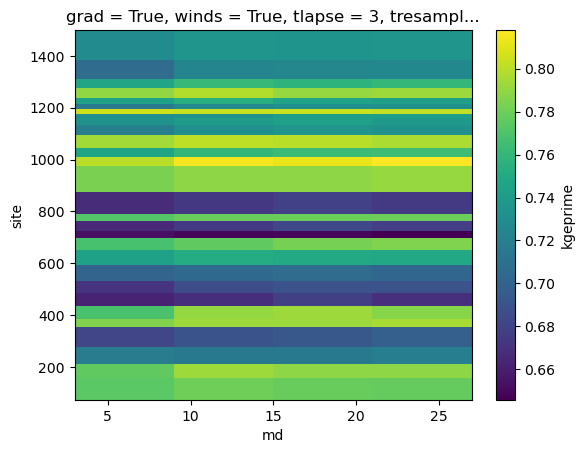

In [20]:
data_xgboost.kgeprime.sel(n_est=100,lr=0.1,mss=0.2).plot()
plt.show()